In [1]:
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from transformers import T5EncoderModel, T5TokenizerFast
import torch
import os
import numpy as np
import librosa
from tqdm import tqdm
import soundfile as sf
import torchaudio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MODEL_PATH = "/blob/v-yuancwang/AudioEditingModel/Diffusion_SG/checkpoint-350000"
CFG = 4.0
TORCH_DEVICE = "cuda:0"
SAVE_MEL_PATH = "/blob/v-yuancwang/audio_editing_test/baseline/inpainting/250/mel"

In [ ]:
model_path = MODEL_PATH
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet")
tokenizer = T5TokenizerFast.from_pretrained(model_path, subfolder="tokenizer")
text_encoder = T5EncoderModel.from_pretrained(model_path, subfolder="text_encoder")

vae.to(TORCH_DEVICE)
text_encoder.to(TORCH_DEVICE)
unet.to(TORCH_DEVICE)
vae.requires_grad_(False)
unet.requires_grad_(False)
text_encoder.requires_grad_(False)

In [ ]:
with open("/home/v-yuancwang/AudioEditing/metadatas/audiocaps_test_metadata.jsonl", "r") as f:
    lines = f.readlines()
lines = [eval(line) for line in lines]
test_set = {}
for line in lines:
    file_name, text = line["file_name"], line["text"]
    file_name = file_name.replace(".wav", "")
    if file_name not in test_set:
        test_set[file_name] = []
    test_set[file_name].append(text)
# print(test_set)

with open("/home/v-yuancwang/AudioEditing/metadatas/audiocaps_inpainting_test.txt") as f:
    lines = f.readlines()
lines = [list(line.replace("\n", "").split(" ")) for line in lines]
mask_loc = {}
for line in lines:
    mask_loc[line[0].replace(".wav", "")] = (line[1], line[2])
mask_loc

In [138]:
file_name = list(test_set.keys())[150]
texts = test_set[file_name]

text = np.random.choice(texts)
# text = ""
# text = "Inpainting: " + text
prompt = [text]
text_input = tokenizer(prompt, max_length=tokenizer.model_max_length, truncation=True, padding="do_not_pad", return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(TORCH_DEVICE))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * 1, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(TORCH_DEVICE))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

mel_src = np.load(os.path.join("/blob/v-yuancwang/audio_editing_data/inpainting_test/mel", file_name+".npy"))
mask_s, mask_e = mask_loc[file_name]
mask_s, mask_e = int(mask_s) / 160000, int(mask_e) / 160000

O90Qy2xG6oA



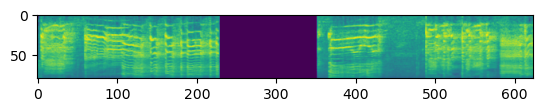

In [139]:
print(file_name)
print(text)
plt.imshow(mel_src)

In [140]:
num_inference_steps = 100
scheduler = PNDMScheduler.from_pretrained(model_path, subfolder="scheduler")
scheduler.set_timesteps(num_inference_steps)
latents_src = torch.Tensor(np.array([[mel_src]])).to(TORCH_DEVICE)
latents_src = vae.encode(latents_src).latent_dist.sample()
guidance_scale = 4.0
strength = 1.0

noise = torch.randn_like(latents_src).to(TORCH_DEVICE)

init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
# print(init_timestep, t_start)
latents = scheduler.add_noise(latents_src, noise, scheduler.timesteps[t_start: t_start+1])
latents[:,:,:,int(78*mask_s): int(78*mask_e)] = torch.randn_like(latents[:,:,:,int(78*mask_s): int(78*mask_e)]).to(TORCH_DEVICE)

for t in tqdm(scheduler.timesteps[t_start:]):

    
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
            
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents_predict = scheduler.step(noise_pred, t, latents).prev_sample

    latents = scheduler.add_noise(latents_src, noise, t-1)
    latents[:,:,:,int(78*mask_s): int(78*mask_e)] = latents_predict[:,:,:,int(78*mask_s): int(78*mask_e)]

latents_out = latents

with torch.no_grad():
     res = vae.decode(latents_out).sample
res = res.cpu().numpy()[0,0,:,:]

# np.save(os.path.join(SAVE_MEL_PATH, file_name + ".npy"), res)

100%|██████████| 101/101 [00:05<00:00, 17.13it/s]


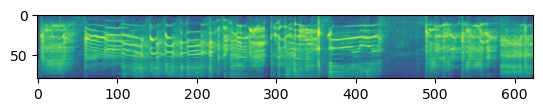

In [142]:
plt.imshow(res)